In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from gplearn.genetic import SymbolicClassifier
from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [3]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None):
    function_vars = None
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names is None:
            function_vars = function.atoms(Symbol)
            print(function_vars)
        else:
            function_vars = [sym.symbols(variable_name, real=True) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        function_values = []
        for data_point in data_points:
            function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
            try:
                function_value = float(function_value)
            except TypeError as te:
                #print('te', te)
                #print('function_value', function_value)
                #print('function', function)
                #print('function_vars', function_vars, type(function_vars))
                function_value = np.inf
            function_values.append(function_value)
    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

In [4]:
def print_decision_tree_nodes(decision_tree): 
    
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

## Load Histograms and Data Statistics

In [5]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [6]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000,-3.043901,-1.0,9.212087,110.625000,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.138240,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625000,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [7]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [8]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [9]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [10]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [11]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [12]:
summarizing_statistics_replica

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[4.05498868e+00 1.61819320e+00 1.43801350e+00...
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,[[ 4.60037788e+00 1.66251134e+00 1.59768757e...
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,[[ 1.53948274e+00 2.18804150e-01 7.78027734e...
off_replica,16741535,-2.791476,4.517446,-1.396657,107.331233,-9.894227,-37.217121,-4.272182,0.000004,8.534652,106.621120,4.482172,2402.991829,[[ 1.77712398e+00 9.46578975e-02 8.42137846e...
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[8.46656243e+00 1.04568770e+01 3.70312553e+00...
all_replica,26381042,-0.944794,6.939326,-0.547978,111.501253,-9.894227,-37.217121,-4.272182,0.000004,10.007755,117.621411,6.767623,2402.992395,[[8.73149553e+00 8.43511366e+00 3.84013568e+00...


In [13]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [14]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [15]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [16]:
pump_data_replica.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
count,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07
mean,-9.447940e-01,6.939326e+00,-5.479782e-01,1.115013e+02,3.653952e-01
std,2.954910e+00,9.601276e+00,1.405716e+00,1.955450e+02,4.815408e-01
min,-9.894227e+00,-3.721712e+01,-4.272182e+00,4.127640e-06,0.000000e+00
25%,-3.370405e+00,1.604177e+00,-1.820977e+00,3.802474e+01,0.000000e+00
50%,-2.187935e+00,4.925814e+00,-9.364350e-01,7.603595e+01,0.000000e+00
75%,1.350188e+00,8.836291e+00,5.890964e-01,1.140709e+02,1.000000e+00
max,1.000776e+01,1.176214e+02,6.767623e+00,2.402992e+03,1.000000e+00


In [17]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [18]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

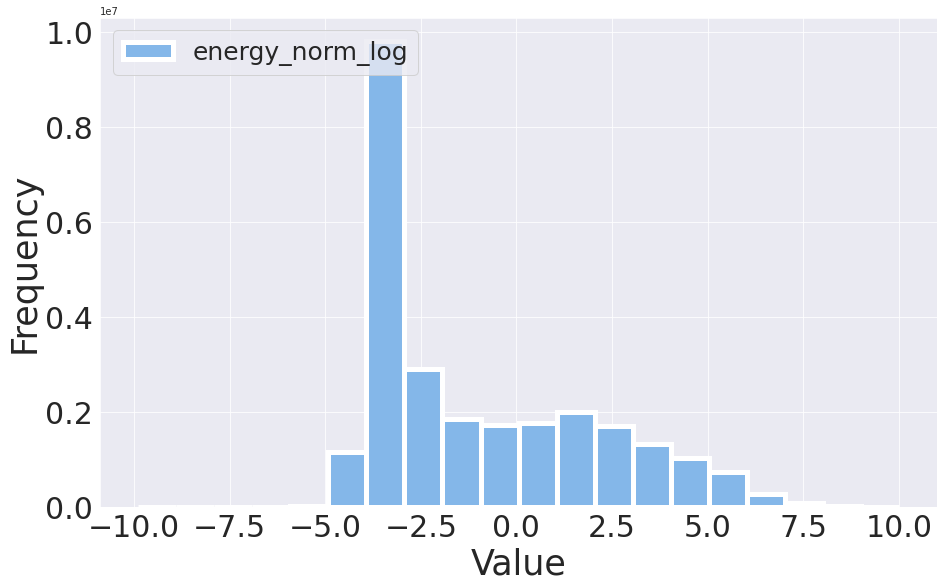

In [19]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

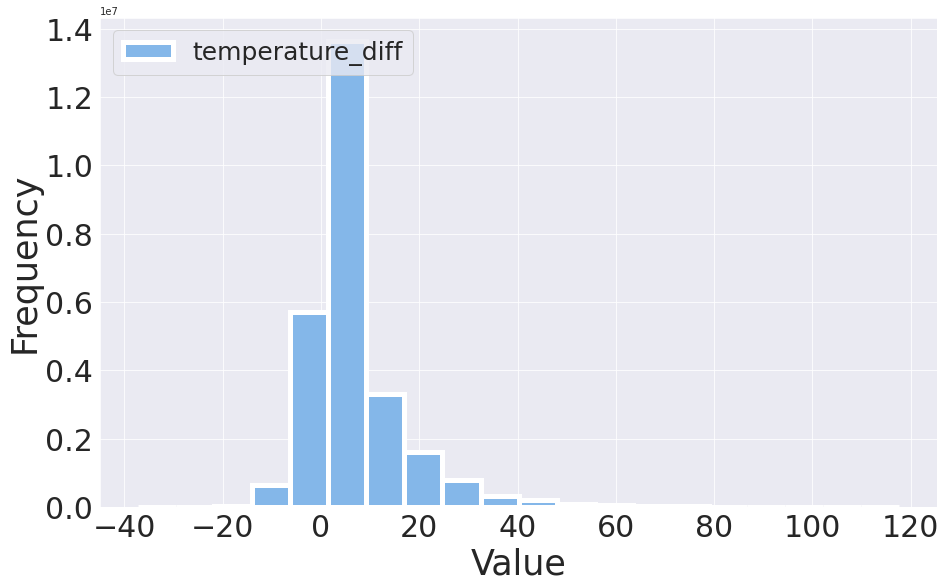

In [20]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

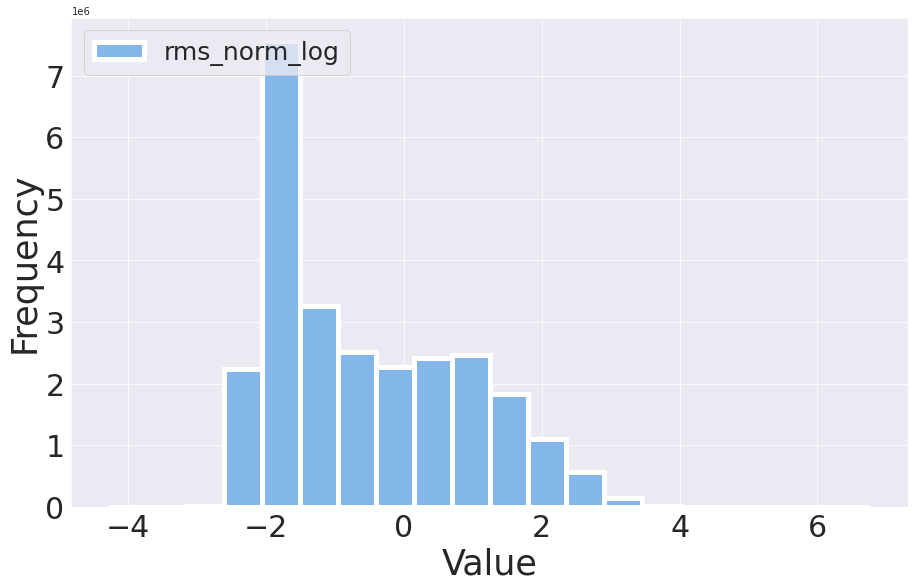

In [21]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

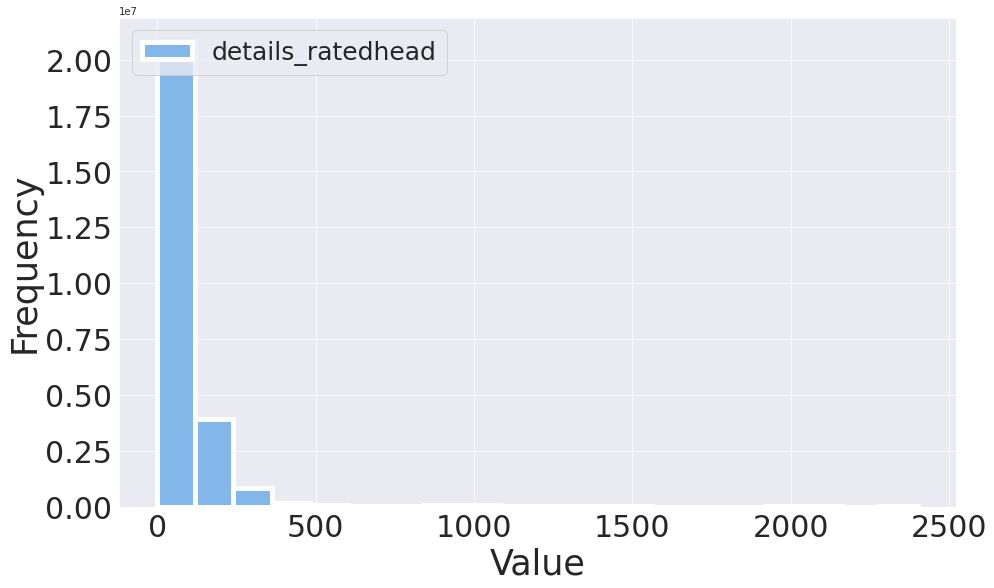

In [22]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [23]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [24]:
data = pump_data_replica.sample(n=10000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1


In [25]:
X_data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,-3.435427,2.008345,-1.831309,44.514913
13018525,-3.043470,4.328306,-2.011905,57.427111
22758968,0.059526,3.589398,0.421158,32.645146
26049008,-3.589604,2.368120,-2.103114,466.114163
4688620,0.485113,9.553305,1.172251,54.346425


In [26]:
y_data.head()

,state
13880350,0
13018525,0
22758968,0
26049008,0
4688620,1


In [27]:
X_data.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.903752,6.957620,-0.529029,108.840560
std,2.940251,9.583776,1.391853,179.754406
min,-5.676228,-22.095298,-2.981257,0.004160
25%,-3.347392,1.625078,-1.804050,38.281687
50%,-2.114641,4.917930,-0.892979,77.509069
75%,1.360277,8.790616,0.605675,114.241249
max,8.326624,108.964905,3.778478,2379.037789


In [28]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 13880350 to 9629643
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy_norm_log    10000 non-null  float64
 1   temperature_diff   10000 non-null  float64
 2   rms_norm_log       10000 non-null  float64
 3   details_ratedhead  10000 non-null  float64
dtypes: float64(4)
memory usage: 390.6 KB


# Symbolic Metamodeling

In [29]:
metamodeling_hyperparams = {
    'num_iter': 50,#500,
    'batch_size': 128,
    'learning_rate': 0.01,        
    'dataset_size': 5000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 20,
    'restarts': 3,
}

symbolic_classification_hyperparams = {     
    'dataset_size': 5000,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True
symbolic_classification = True

In [30]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.9024

In [31]:
data = pump_data_replica.sample(n=metamodeling_hyperparams['dataset_size'])

data_scaled = np.empty_like(data.values.T[:-1])
scaler_list = []

for index, feature in enumerate(data.values.T[:-1]):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    data_scaled[index] = feature_scaled
    
data_scaled = pd.DataFrame(data= data_scaled.T, index=data.index, columns=list(data.columns)[:-1])

In [32]:
data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
3228774,0.722642,5.048562,0.478871,102.441835,1
6648753,2.069493,24.442959,1.769626,66.284119,1
25558960,-1.145248,4.071129,-0.063827,184.503801,0
17578382,-3.199043,4.780609,-1.628835,27.827720,0
4363318,1.854438,2.216334,0.973370,60.624418,1


In [33]:
data_scaled.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
3228774,0.444761,0.210039,0.513313,0.042952
6648753,0.543485,0.410551,0.707789,0.027825
25558960,0.307845,0.199934,0.431546,0.077285
17578382,0.157302,0.207269,0.195749,0.011735
4363318,0.527721,0.180758,0.587818,0.025457


In [34]:
X_data = data.drop(['state'], axis=1).values #frac=0.1
y_data = data[['state']].values #frac=0.1

X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   


In [35]:
X_data_scaled = data_scaled.values 
X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

In [36]:
print(X_data.shape)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()

print(y_data.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(5000, 4)
(2812, 4)
(938, 4)
(1250, 4)

(5000, 1)
(2812, 1)
(938, 1)
(1250, 1)


## Evaluate Model

In [37]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))


Accuracy: 0.904


In [38]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train, 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [39]:
%load_ext autoreload 

In [40]:
if False:
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from xgboost import XGBClassifier
    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split


    data          = pd.read_csv("data/absenteeism.csv", delimiter=';')

    feature_names = ['Transportation expense', 'Distance from Residence to Work',
                     'Service time', 'Age', 'Work load Average/day ', 'Hit target',
                     'Disciplinary failure', 'Education', 'Son', 'Social drinker',
                     'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']

    scaler        = MinMaxScaler(feature_range=(0, 1))
    X             = scaler.fit_transform(data[feature_names])
    Y             = ((data['Absenteeism time in hours'] > 4) * 1) 

    X_train_abse, X_test_abse, Y_train_abse, Y_test_abse = train_test_split(X, Y, test_size=0.33, random_state=42)

    model         = XGBClassifier()

    model.fit(X_train_abse, Y_train_abse)

In [41]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]:  
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [42]:
#%autoreload 2
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_train_scaled.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled, #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model_scaled.predict(X_test_scaled)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]


restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.646
Iteration: 1 	--- Loss: 37.460
Iteration: 2 	--- Loss: 35.991
Iteration: 3 	--- Loss: 34.575
Iteration: 4 	--- Loss: 36.200
Iteration: 5 	--- Loss: 35.033
Iteration: 6 	--- Loss: 37.936
Iteration: 7 	--- Loss: 35.406
Iteration: 8 	--- Loss: 35.919
Iteration: 9 	--- Loss: 34.673
Iteration: 10 	--- Loss: 34.465
Iteration: 11 	--- Loss: 35.377
Iteration: 12 	--- Loss: 33.843
Iteration: 13 	--- Loss: 34.505
Iteration: 14 	--- Loss: 34.786
Iteration: 15 	--- Loss: 34.438
Iteration: 16 	--- Loss: 34.781
Iteration: 17 	--- Loss: 34.331
Iteration: 18 	--- Loss: 33.411
Iteration: 19 	--- Loss: 34.643
Iteration: 20 	--- Loss: 34.156
Iteration: 21 	--- Loss: 33.653
Iteration: 22 	--- Loss: 34.423
Iteration: 23 	--- Loss: 33.260
Iteration: 24 	--- Loss: 34.378
Iteration: 25 	--- Loss: 35.976
Iteration: 26 	--- Loss: 34.568
Iteration: 27 	--- Loss: 34.797
Iteration: 28 	--- Loss: 45.282
Iteration: 29 	--- Loss: 38.218
Iteration: 30 	--- Loss: 40.232
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [12:20<37:01, 740.38s/it]

Iteration: 133 	--- Loss: 32.735
Early Stopping requirement reached after 133 Iterations
New Global Minimum: 28.86798577714499


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.815
Iteration: 1 	--- Loss: 37.752
Iteration: 2 	--- Loss: 38.445
Iteration: 3 	--- Loss: 37.992
Iteration: 4 	--- Loss: 35.486
Iteration: 5 	--- Loss: 37.165
Iteration: 6 	--- Loss: 37.302
Iteration: 7 	--- Loss: 35.551
Iteration: 8 	--- Loss: 34.741
Iteration: 9 	--- Loss: 34.912
Iteration: 10 	--- Loss: 34.634
Iteration: 11 	--- Loss: 34.769
Iteration: 12 	--- Loss: 34.724
Iteration: 13 	--- Loss: 35.772
Iteration: 14 	--- Loss: 34.591
Iteration: 15 	--- Loss: 35.214
Iteration: 16 	--- Loss: 34.993
Iteration: 17 	--- Loss: 35.935
Iteration: 18 	--- Loss: 35.496
Iteration: 19 	--- Loss: 40.866
Iteration: 20 	--- Loss: 51.212
Iteration: 21 	--- Loss: 50.571
Iteration: 22 	--- Loss: 44.625
Iteration: 23 	--- Loss: 38.845
Iteration: 24 	--- Loss: 31.059
Iteration: 25 	--- Loss: 38.594
Iteration: 26 	--- Loss: 41.265
Iteration: 27 	--- Loss: 41.327
Iteration: 28 	--- Loss: 39.003
Iteration: 29 	--- Loss: 37.609
Iteration: 30 	--- Loss: 36.948
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [16:30<15:03, 451.89s/it]

Iteration: 45 	--- Loss: 35.431
Early Stopping requirement reached after 45 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.757
Iteration: 1 	--- Loss: 35.519
Iteration: 2 	--- Loss: 37.214
Iteration: 3 	--- Loss: 35.801
Iteration: 4 	--- Loss: 35.515
Iteration: 5 	--- Loss: 32.240
Iteration: 6 	--- Loss: 35.825
Iteration: 7 	--- Loss: 37.018
Iteration: 8 	--- Loss: 32.812
Iteration: 9 	--- Loss: 33.942
Iteration: 10 	--- Loss: 33.234
Iteration: 11 	--- Loss: 31.906
Iteration: 12 	--- Loss: 32.169
Iteration: 13 	--- Loss: 37.010
Iteration: 14 	--- Loss: 47.944
Iteration: 15 	--- Loss: 50.301
Iteration: 16 	--- Loss: 54.090
Iteration: 17 	--- Loss: 46.868
Iteration: 18 	--- Loss: 34.794
Iteration: 19 	--- Loss: 35.934
Iteration: 20 	--- Loss: 42.859
Iteration: 21 	--- Loss: 44.511
Iteration: 22 	--- Loss: 39.308
Iteration: 23 	--- Loss: 38.802
Iteration: 24 	--- Loss: 37.342
Iteration: 25 	--- Loss: 37.647
Iteration: 26 	--- Loss: 36.009
Iteration: 27 	--- Loss: 35.111
Iteration: 28 	--- Loss: 35.142
Iteration: 29 	--- Loss: 34.763
Iteration: 30 	--- Loss: 34.355
Iteration: 31 	---


restart loop:  75%|███████▌  | 3/4 [19:34<05:29, 329.76s/it]

Iteration: 32 	--- Loss: 34.345
Early Stopping requirement reached after 32 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 34.349
Iteration: 1 	--- Loss: 35.789
Iteration: 2 	--- Loss: 38.013
Iteration: 3 	--- Loss: 38.293
Iteration: 4 	--- Loss: 35.803
Iteration: 5 	--- Loss: 38.202
Iteration: 6 	--- Loss: 38.477
Iteration: 7 	--- Loss: 39.279
Iteration: 8 	--- Loss: 36.385
Iteration: 9 	--- Loss: 34.281
Iteration: 10 	--- Loss: 34.719
Iteration: 11 	--- Loss: 35.088
Iteration: 12 	--- Loss: 33.709
Iteration: 13 	--- Loss: 35.678
Iteration: 14 	--- Loss: 31.526
Iteration: 15 	--- Loss: 31.782
Iteration: 16 	--- Loss: 31.495
Iteration: 17 	--- Loss: 33.224
Iteration: 18 	--- Loss: 35.040
Iteration: 19 	--- Loss: 40.129
Iteration: 20 	--- Loss: 48.725
Iteration: 21 	--- Loss: 53.292
Iteration: 22 	--- Loss: 43.791
Iteration: 23 	--- Loss: 32.708
Iteration: 24 	--- Loss: 36.466
Iteration: 25 	--- Loss: 39.899
Iteration: 26 	--- Loss: 41.262
Iteration: 27 	--- Loss: 40.424
Iteration: 28 	--- Loss: 41.360
Iteration: 29 	--- Loss: 37.589
Iteration: 30 	--- Loss: 37.033
Iteration: 31 	---


restart loop: 100%|██████████| 4/4 [22:57<00:00, 344.39s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 37 	--- Loss: 34.423
Early Stopping requirement reached after 37 Iterations
return abc 2.8971727 1.763062 2.9381962


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.099
Iteration: 1 	--- Loss: 37.738
Iteration: 2 	--- Loss: 36.477
Iteration: 3 	--- Loss: 35.981
Iteration: 4 	--- Loss: 37.398
Iteration: 5 	--- Loss: 35.023
Iteration: 6 	--- Loss: 38.936
Iteration: 7 	--- Loss: 36.206
Iteration: 8 	--- Loss: 38.346
Iteration: 9 	--- Loss: 36.693
Iteration: 10 	--- Loss: 35.780
Iteration: 11 	--- Loss: 36.619
Iteration: 12 	--- Loss: 40.545
Iteration: 13 	--- Loss: 40.370
Iteration: 14 	--- Loss: 35.606
Iteration: 15 	--- Loss: 37.460
Iteration: 16 	--- Loss: 36.127
Iteration: 17 	--- Loss: 35.045
Iteration: 18 	--- Loss: 36.049
Iteration: 19 	--- Loss: 38.633
Iteration: 20 	--- Loss: 34.835
Iteration: 21 	--- Loss: 37.337
Iteration: 22 	--- Loss: 37.618
Iteration: 23 	--- Loss: 36.846
Iteration: 24 	--- Loss: 36.562
Iteration: 25 	--- Loss: 38.431
Iteration: 26 	--- Loss: 35.354
Iteration: 27 	--- Loss: 36.380
Iteration: 28 	--- Loss: 35.375
Iteration: 29 	--- Loss: 37.921
Iteration: 30 	--- Loss: 37.254
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [02:43<08:11, 163.80s/it]

Iteration: 41 	--- Loss: 36.833
Early Stopping requirement reached after 41 Iterations
New Global Minimum: 34.835389613405


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 40.165
Iteration: 1 	--- Loss: 38.991
Iteration: 2 	--- Loss: 36.918
Iteration: 3 	--- Loss: 38.007
Iteration: 4 	--- Loss: 40.484
Iteration: 5 	--- Loss: 37.952
Iteration: 6 	--- Loss: 39.581
Iteration: 7 	--- Loss: 38.630
Iteration: 8 	--- Loss: 37.171
Iteration: 9 	--- Loss: 40.446
Iteration: 10 	--- Loss: 36.099
Wrong c Value: -0.039582126
te can't convert complex to float
function_value 2.44912016324924e-5 + 1.28918425588604e-5*I
function 0.000972498011161474*x**2.15423*exp(2.15423*I*pi)*hyper((1.0, 1.0), (1.03881,), 0.0395821258425713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.12829325397151e-5 + 1.12030524108233e-5*I
function 0.000972498011161474*x**2.15423*exp(2.15423*I*pi)*hyper((1.0, 1.0), (1.03881,), 0.0395821258425713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.83755274211834e-5 + 1.49364999532404e-5*I
function 0.0009724980111614


restart loop:  50%|█████     | 2/4 [03:33<03:13, 96.94s/it] 

te can't convert complex to float
function_value 0.000126354634400069 + 6.6511397754651e-5*I
function 0.000972498011161474*x**2.15423*exp(2.15423*I*pi)*hyper((1.0, 1.0), (1.03881,), 0.0395821258425713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.89489553399186e-5 + 4.15576792719891e-5*I
function 0.000972498011161474*x**2.15423*exp(2.15423*I*pi)*hyper((1.0, 1.0), (1.03881,), 0.0395821258425713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.59773647583773e-5 + 1.36741390473379e-5*I
function 0.000972498011161474*x**2.15423*exp(2.15423*I*pi)*hyper((1.0, 1.0), (1.03881,), 0.0395821258425713*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.84088788854377e-5 + 9.69018882116982e-6*I
function 0.000972498011161474*x**2.15423*exp(2.15423*I*pi)*hyper((1.0, 1.0), (1.03881,), 0.0395821258425713*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.132
Iteration: 1 	--- Loss: 36.689
Iteration: 2 	--- Loss: 37.857
Iteration: 3 	--- Loss: 37.680
Iteration: 4 	--- Loss: 37.154
Iteration: 5 	--- Loss: 38.699
Iteration: 6 	--- Loss: 36.150
Iteration: 7 	--- Loss: 39.288
Iteration: 8 	--- Loss: 37.121
Iteration: 9 	--- Loss: 36.949
Iteration: 10 	--- Loss: 38.367
Iteration: 11 	--- Loss: 35.376
Wrong c Value: -0.05607062
te can't convert complex to float
function_value -1.15415147908126e-6 + 1.39971255184947e-6*I
function 0.000433604470611945*x**2.71949*exp(2.71949*I*pi)*hyper((1.0, 1.0), (1.22364,), 0.0560706183314323*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.23302600796909e-6 + 3.92089527746599e-6*I
function 0.000433604470611945*x**2.71949*exp(2.71949*I*pi)*hyper((1.0, 1.0), (1.22364,), 0.0560706183314323*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.16569120498583e-5 + 1.4137075078723


restart loop:  75%|███████▌  | 3/4 [04:28<01:17, 77.77s/it]

te can't convert complex to float
function_value -2.13996812521893e-6 + 2.59527479686729e-6*I
function 0.000433604470611945*x**2.71949*exp(2.71949*I*pi)*hyper((1.0, 1.0), (1.22364,), 0.0560706183314323*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.64350175780278e-6 + 1.04825216807417e-5*I
function 0.000433604470611945*x**2.71949*exp(2.71949*I*pi)*hyper((1.0, 1.0), (1.22364,), 0.0560706183314323*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.40234953263985e-6 + 2.91348133733921e-6*I
function 0.000433604470611945*x**2.71949*exp(2.71949*I*pi)*hyper((1.0, 1.0), (1.22364,), 0.0560706183314323*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.30053431993665e-6 + 5.2155301763911e-6*I
function 0.000433604470611945*x**2.71949*exp(2.71949*I*pi)*hyper((1.0, 1.0), (1.22364,), 0.0560706183314323*x*exp_polar(2*I*pi))
function_v

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.134
Iteration: 1 	--- Loss: 37.256
Iteration: 2 	--- Loss: 38.516
Iteration: 3 	--- Loss: 40.242
Iteration: 4 	--- Loss: 36.663
Iteration: 5 	--- Loss: 36.377
Iteration: 6 	--- Loss: 38.282
Iteration: 7 	--- Loss: 37.561
Iteration: 8 	--- Loss: 37.394
Iteration: 9 	--- Loss: 35.518
Iteration: 10 	--- Loss: 37.850
Iteration: 11 	--- Loss: 37.358
Iteration: 12 	--- Loss: 38.155
Iteration: 13 	--- Loss: 38.441
Iteration: 14 	--- Loss: 37.925
Iteration: 15 	--- Loss: 37.719
Iteration: 16 	--- Loss: 36.238
Iteration: 17 	--- Loss: 36.147
Iteration: 18 	--- Loss: 39.007
Iteration: 19 	--- Loss: 36.895
Iteration: 20 	--- Loss: 36.986
Iteration: 21 	--- Loss: 36.058
Iteration: 22 	--- Loss: 38.539
Iteration: 23 	--- Loss: 36.981
Iteration: 24 	--- Loss: 36.716
Iteration: 25 	--- Loss: 36.101
Iteration: 26 	--- Loss: 37.419
Iteration: 27 	--- Loss: 36.830
Wrong c Value: -0.01447831
te can't convert complex to float
function_value 3.30247276250782e-11 - 3.2585711701509


restart loop: 100%|██████████| 4/4 [06:28<00:00, 97.18s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

te can't convert complex to float
function_value 6.39284367259757e-11 - 6.3078600748214e-12*I
function 3.54330992561265e-8*x**3.96869*exp(3.96869*I*pi)*hyper((1.0, 1.0), (2.58714,), 0.0144783100113273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.0532949884823e-10 - 6.95953164700296e-11*I
function 3.54330992561265e-8*x**3.96869*exp(3.96869*I*pi)*hyper((1.0, 1.0), (2.58714,), 0.0144783100113273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.97949509698666e-11 - 3.92659347323444e-12*I
function 3.54330992561265e-8*x**3.96869*exp(3.96869*I*pi)*hyper((1.0, 1.0), (2.58714,), 0.0144783100113273*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6.35608487079823e-11 - 6.27158992805367e-12*I
function 3.54330992561265e-8*x**3.96869*exp(3.96869*I*pi)*hyper((1.0, 1.0), (2.58714,), 0.0144783100113273*x*exp_polar(2*I*pi))
function_va

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.257
Iteration: 1 	--- Loss: 35.684
Iteration: 2 	--- Loss: 34.041
Iteration: 3 	--- Loss: 33.559
Iteration: 4 	--- Loss: 34.146
Iteration: 5 	--- Loss: 35.310
Iteration: 6 	--- Loss: 36.462
Iteration: 7 	--- Loss: 36.169
Iteration: 8 	--- Loss: 32.828
Iteration: 9 	--- Loss: 33.824
Iteration: 10 	--- Loss: 33.709
Iteration: 11 	--- Loss: 34.595
Iteration: 12 	--- Loss: 36.299
Iteration: 13 	--- Loss: 30.821
Iteration: 14 	--- Loss: 34.748
Iteration: 15 	--- Loss: 33.287
Iteration: 16 	--- Loss: 35.108
Iteration: 17 	--- Loss: 33.301
Iteration: 18 	--- Loss: 37.432
Iteration: 19 	--- Loss: 33.887
Iteration: 20 	--- Loss: 33.838
Iteration: 21 	--- Loss: 33.715
Iteration: 22 	--- Loss: 36.034
Iteration: 23 	--- Loss: 36.501
Iteration: 24 	--- Loss: 41.750
Iteration: 25 	--- Loss: 40.091
Iteration: 26 	--- Loss: 42.875
Iteration: 27 	--- Loss: 44.592
Iteration: 28 	--- Loss: 41.635
Iteration: 29 	--- Loss: 38.451
Iteration: 30 	--- Loss: 39.342
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [03:01<09:05, 181.70s/it]

Iteration: 34 	--- Loss: 37.434
Early Stopping requirement reached after 34 Iterations
New Global Minimum: 30.821438181192896


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.982
Iteration: 1 	--- Loss: 40.654
Iteration: 2 	--- Loss: 36.843
Iteration: 3 	--- Loss: 38.136
Iteration: 4 	--- Loss: 39.649
Iteration: 5 	--- Loss: 35.983
Iteration: 6 	--- Loss: 38.853
Iteration: 7 	--- Loss: 39.066
Iteration: 8 	--- Loss: 34.639
Iteration: 9 	--- Loss: 38.161
Iteration: 10 	--- Loss: 38.068
Iteration: 11 	--- Loss: 37.079
Iteration: 12 	--- Loss: 36.416
Iteration: 13 	--- Loss: 36.470
Iteration: 14 	--- Loss: 38.543
Iteration: 15 	--- Loss: 35.641
Iteration: 16 	--- Loss: 37.881
Iteration: 17 	--- Loss: 36.249
Iteration: 18 	--- Loss: 36.089
Iteration: 19 	--- Loss: 35.506
Iteration: 20 	--- Loss: 36.979
Iteration: 21 	--- Loss: 35.509
Iteration: 22 	--- Loss: 36.202
Iteration: 23 	--- Loss: 37.448
Iteration: 24 	--- Loss: 34.722
Iteration: 25 	--- Loss: 38.410
Iteration: 26 	--- Loss: 36.814
Iteration: 27 	--- Loss: 35.737
Iteration: 28 	--- Loss: 33.711
Iteration: 29 	--- Loss: 35.790
Iteration: 30 	--- Loss: 34.736
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [08:35<09:02, 271.10s/it]

Iteration: 65 	--- Loss: 33.436
Early Stopping requirement reached after 65 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.155
Iteration: 1 	--- Loss: 39.515
Iteration: 2 	--- Loss: 37.507
Iteration: 3 	--- Loss: 39.197
Iteration: 4 	--- Loss: 36.122
Iteration: 5 	--- Loss: 36.932
Iteration: 6 	--- Loss: 37.649
Iteration: 7 	--- Loss: 37.918
Iteration: 8 	--- Loss: 36.143
Iteration: 9 	--- Loss: 38.462
Iteration: 10 	--- Loss: 37.163
Iteration: 11 	--- Loss: 35.851
Iteration: 12 	--- Loss: 36.615
Iteration: 13 	--- Loss: 35.759
Iteration: 14 	--- Loss: 36.463
Iteration: 15 	--- Loss: 39.061
Iteration: 16 	--- Loss: 35.812
Iteration: 17 	--- Loss: 35.802
Iteration: 18 	--- Loss: 37.825
Iteration: 19 	--- Loss: 35.007
Iteration: 20 	--- Loss: 34.522
Iteration: 21 	--- Loss: 36.891
Iteration: 22 	--- Loss: 34.683
Iteration: 23 	--- Loss: 37.941
Iteration: 24 	--- Loss: 37.018
Iteration: 25 	--- Loss: 38.007
Iteration: 26 	--- Loss: 33.782
Iteration: 27 	--- Loss: 37.146
Iteration: 28 	--- Loss: 40.062
Iteration: 29 	--- Loss: 33.495
Iteration: 30 	--- Loss: 35.651
Iteration: 31 	---


restart loop:  75%|███████▌  | 3/4 [12:07<04:04, 244.22s/it]

Iteration: 50 	--- Loss: 37.376
Early Stopping requirement reached after 50 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.224
Iteration: 1 	--- Loss: 37.149
Iteration: 2 	--- Loss: 37.539
Iteration: 3 	--- Loss: 37.224
Iteration: 4 	--- Loss: 35.681
Iteration: 5 	--- Loss: 36.481
Iteration: 6 	--- Loss: 38.183
Iteration: 7 	--- Loss: 36.334
Iteration: 8 	--- Loss: 34.464
Iteration: 9 	--- Loss: 36.883
Iteration: 10 	--- Loss: 39.050
Iteration: 11 	--- Loss: 34.347
Iteration: 12 	--- Loss: 38.181
Iteration: 13 	--- Loss: 36.719
Iteration: 14 	--- Loss: 37.393
Iteration: 15 	--- Loss: 38.192
Iteration: 16 	--- Loss: 36.723
Iteration: 17 	--- Loss: 37.577
Iteration: 18 	--- Loss: 35.357
Iteration: 19 	--- Loss: 35.531
Iteration: 20 	--- Loss: 34.364
Iteration: 21 	--- Loss: 37.191
Iteration: 22 	--- Loss: 36.092
Iteration: 23 	--- Loss: 39.131
Iteration: 24 	--- Loss: 40.391
Iteration: 25 	--- Loss: 35.539
Iteration: 26 	--- Loss: 39.338
Iteration: 27 	--- Loss: 40.865
Iteration: 28 	--- Loss: 36.892
Iteration: 29 	--- Loss: 37.138
Iteration: 30 	--- Loss: 35.161
Iteration: 31 	---


restart loop: 100%|██████████| 4/4 [14:29<00:00, 217.32s/it]

restart loop:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration: 32 	--- Loss: 36.752
Early Stopping requirement reached after 32 Iterations
return abc 3.3704531 1.5150515 2.3493247


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.645
Iteration: 1 	--- Loss: 36.361
Iteration: 2 	--- Loss: 38.873
Iteration: 3 	--- Loss: 37.422
Iteration: 4 	--- Loss: 36.196
Iteration: 5 	--- Loss: 38.023
Iteration: 6 	--- Loss: 37.433
Iteration: 7 	--- Loss: 39.009
Iteration: 8 	--- Loss: 37.402
Iteration: 9 	--- Loss: 36.847
Iteration: 10 	--- Loss: 37.187
Iteration: 11 	--- Loss: 39.992
Iteration: 12 	--- Loss: 39.291
Iteration: 13 	--- Loss: 37.874
Iteration: 14 	--- Loss: 39.015
Iteration: 15 	--- Loss: 35.700
Iteration: 16 	--- Loss: 37.688
Iteration: 17 	--- Loss: 39.355
Iteration: 18 	--- Loss: 38.124
Iteration: 19 	--- Loss: 37.584
Iteration: 20 	--- Loss: 37.036
Iteration: 21 	--- Loss: 36.040
Iteration: 22 	--- Loss: 38.035
Iteration: 23 	--- Loss: 37.982
Iteration: 24 	--- Loss: 39.060
Iteration: 25 	--- Loss: 37.063
Iteration: 26 	--- Loss: 36.254
Iteration: 27 	--- Loss: 38.323
Iteration: 28 	--- Loss: 35.948
Iteration: 29 	--- Loss: 36.858
Iteration: 30 	--- Loss: 37.288
Iteration: 31 	---


restart loop:  25%|██▌       | 1/4 [02:55<08:45, 175.31s/it]

Iteration: 36 	--- Loss: 38.366
Early Stopping requirement reached after 36 Iterations
New Global Minimum: 35.69960344426292


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.813
Iteration: 1 	--- Loss: 36.286
Iteration: 2 	--- Loss: 37.772
Iteration: 3 	--- Loss: 37.511
Iteration: 4 	--- Loss: 39.252
Iteration: 5 	--- Loss: 37.656
Iteration: 6 	--- Loss: 38.160
Iteration: 7 	--- Loss: 37.316
Iteration: 8 	--- Loss: 36.900
Iteration: 9 	--- Loss: 39.103
Iteration: 10 	--- Loss: 36.267
Iteration: 11 	--- Loss: 36.382
Iteration: 12 	--- Loss: 36.690
Iteration: 13 	--- Loss: 36.235
Iteration: 14 	--- Loss: 39.124
Iteration: 15 	--- Loss: 35.856
Iteration: 16 	--- Loss: 36.046
Iteration: 17 	--- Loss: 37.678
Iteration: 18 	--- Loss: 35.286
Iteration: 19 	--- Loss: 38.063
Iteration: 20 	--- Loss: 36.015
Iteration: 21 	--- Loss: 36.133
Iteration: 22 	--- Loss: 33.607
Iteration: 23 	--- Loss: 33.704
Iteration: 24 	--- Loss: 31.624
Iteration: 25 	--- Loss: 33.885
Iteration: 26 	--- Loss: 36.072
Iteration: 27 	--- Loss: 32.868
Iteration: 28 	--- Loss: 33.440
Iteration: 29 	--- Loss: 32.371
Iteration: 30 	--- Loss: 35.210
Iteration: 31 	---


restart loop:  50%|█████     | 2/4 [08:12<08:37, 258.86s/it]

Iteration: 73 	--- Loss: 35.309
Early Stopping requirement reached after 73 Iterations
New Global Minimum: 30.914896207000513


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.381
Iteration: 1 	--- Loss: 38.718
Iteration: 2 	--- Loss: 40.446
Iteration: 3 	--- Loss: 35.239
Iteration: 4 	--- Loss: 36.047
Iteration: 5 	--- Loss: 39.434
Iteration: 6 	--- Loss: 40.285
Iteration: 7 	--- Loss: 38.921
Iteration: 8 	--- Loss: 37.694
Iteration: 9 	--- Loss: 35.919
Iteration: 10 	--- Loss: 36.066
Iteration: 11 	--- Loss: 37.464
Iteration: 12 	--- Loss: 38.563
Iteration: 13 	--- Loss: 39.751
Iteration: 14 	--- Loss: 36.098
Iteration: 15 	--- Loss: 34.940
Iteration: 16 	--- Loss: 36.107
Iteration: 17 	--- Loss: 37.615
Iteration: 18 	--- Loss: 37.620
Iteration: 19 	--- Loss: 37.808
Iteration: 20 	--- Loss: 37.121
Iteration: 21 	--- Loss: 36.758
Iteration: 22 	--- Loss: 34.093
Iteration: 23 	--- Loss: 32.398
Iteration: 24 	--- Loss: 31.675
Iteration: 25 	--- Loss: 33.765
Iteration: 26 	--- Loss: 34.712
Iteration: 27 	--- Loss: 32.276
Iteration: 28 	--- Loss: 33.998
Iteration: 29 	--- Loss: 32.720
Iteration: 30 	--- Loss: 31.746
Iteration: 31 	---

te can't convert complex to float
function_value -0.781023519242751 + 0.946094213236703*I
function -0.522020623465243*x**(-0.280331)*exp(-0.280331*I*pi)*hyper((1.0, 1.0), (-0.598947,), 0.0961404964327812*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.20608107930712 + 1.46098843596039*I
function -0.522020623465243*x**(-0.280331)*exp(-0.280331*I*pi)*hyper((1.0, 1.0), (-0.598947,), 0.0961404964327812*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -0.753623615636562 + 0.912903291828609*I
function -0.522020623465243*x**(-0.280331)*exp(-0.280331*I*pi)*hyper((1.0, 1.0), (-0.598947,), 0.0961404964327812*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.07141794266387 + 1.29786400862175*I
function -0.522020623465243*x**(-0.280331)*exp(-0.280331*I*pi)*hyper((1.0, 1.0), (-0.598947,), 0.0961404964327812*x*exp_polar(2*I*pi))
funct

restart loop:  75%|███████▌  | 3/4 [10:57<03:35, 215.86s/it]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.792
Iteration: 1 	--- Loss: 35.307
Iteration: 2 	--- Loss: 38.665
Iteration: 3 	--- Loss: 38.668
Iteration: 4 	--- Loss: 37.609
Iteration: 5 	--- Loss: 37.068
Iteration: 6 	--- Loss: 36.521
Iteration: 7 	--- Loss: 36.344
Iteration: 8 	--- Loss: 37.859
Iteration: 9 	--- Loss: 36.152
Iteration: 10 	--- Loss: 37.410
Iteration: 11 	--- Loss: 38.500
Iteration: 12 	--- Loss: 35.733
Wrong c Value: -0.08760517
te can't convert complex to float
function_value -2.83029493221142e-8 - 3.62561969970189e-9*I
function 0.000686771348185686*x**3.04055*exp(3.04055*I*pi)*hyper((1.0, 1.0), (1.51782,), 0.0876051709055901*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -7.97221180207305e-8 - 1.02124368138581e-8*I
function 0.000686771348185686*x**3.04055*exp(3.04055*I*pi)*hyper((1.0, 1.0), (1.51782,), 0.0876051709055901*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.515


restart loop: 100%|██████████| 4/4 [11:55<00:00, 178.98s/it]


function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.60397303485356e-8 - 7.17871300284882e-9*I
function 0.000686771348185686*x**3.04055*exp(3.04055*I*pi)*hyper((1.0, 1.0), (1.51782,), 0.0876051709055901*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -7.60822639387437e-9 - 9.74616997666384e-10*I
function 0.000686771348185686*x**3.04055*exp(3.04055*I*pi)*hyper((1.0, 1.0), (1.51782,), 0.0876051709055901*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 13 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -9.060816955140503
a_new, b_new, c_new nan nan nan
best_parameters abc 1.5425162 1.2661599 1.466437
return abc -0.37419578 1.1051601 0.06383879


----  Optimizing the metamodel  ----


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.835
Iteration: 1 	--- Loss: 40.136
Iteration: 2 	--- Loss: 41.122
Iteration: 3 	--- Loss: 31.223
Iteration: 4 	--- Loss: 35.908
Iteration: 5 	--- Loss: 37.835
Iteration: 6 	--- Loss: 35.927
Iteration: 7 	--- Loss: 47.880
Iteration: 8 	--- Loss: 45.008
Iteration: 9 	--- Loss: 43.032
Iteration: 10 	--- Loss: 38.582
Iteration: 11 	--- Loss: 36.514
Iteration: 12 	--- Loss: 41.482
Iteration: 13 	--- Loss: 36.513
Iteration: 14 	--- Loss: 39.516
Iteration: 15 	--- Loss: 39.267
Iteration: 16 	--- Loss: 44.285
Iteration: 17 	--- Loss: 37.741
Iteration: 18 	--- Loss: 43.964
Iteration: 19 	--- Loss: 43.659
Iteration: 20 	--- Loss: 45.187
Iteration: 21 	--- Loss: 42.558
Iteration: 22 	--- Loss: 38.976
Iteration: 23 	--- Loss: 36.187
Iteration: 24 	--- Loss: 43.312
Early Stopping requirement reached after 24 Iterations


1/(exp(67.508701969657*re(X0**2.85719374780704*hyper((1.0, 1.0), (2.05417234243074,), 2.97814363589651*X0*exp_polar(I*pi))) + 0.00675128496827258*re(X1**2.95233891578082*hyper((1.0, 1.0), (3.68496797197188,), 0.29631896067952*X1*exp_polar(I*pi))) + 45.4740787727388*re(X2**3.33129988969196*hyper((1.0, 1.0), (2.8157322392209,), 2.34072343213284*X2*exp_polar(I*pi))) + 0.898889106611229*re(X3**(-0.33553550646385)*hyper((1.0, 1.0), (-0.401408918490183,), 0.101485412761083*X3*exp_polar(I*pi))) - 36.1257072750545*re((X0*X1)**1.36569482589064*hyper((1.0, 1.0), (1.30652719781895,), 1.45239867461256*X0*X1*exp_polar(I*pi))) - 125.25674482804*re((X0*X2)**1.35377771517801*hyper((1.0, 1.0), (1.293285141628,), 1.47961361130387*X0*X2*exp_polar(I*pi))) - 27.1505338169729*re((X0*X3)**1.40390314217083*hyper((1.0, 1.0), (1.34997101684425,), 1.46149403482229*X0*X3*exp_polar(I*pi))) + 15.5816843649659*re((X1*X2)**1.36059776920522*hyper((1.0, 1.0), (1.30125486223757,), 1.45269647282114*X1*X2*exp_polar(I*pi))

Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.892
Accuracy Symbolic Metaodel Eval: 0.8976
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.8984
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.904
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.8501664816870144
F1 Score Symbolic Metaodel Eval: 0.8596491228070176
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.8555176336746302
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.8651685393258426


In [43]:
y_test[:50].ravel()

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1])

In [44]:
y_test_model[:50]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1])

In [45]:
calculate_function_values_from_sympy(metamodel_function, X_test_scaled[:50])

array([0.00989354, 0.00489831, 0.21737386, 0.1235854 , 0.18999835,
       0.10185222, 0.89559511, 0.16386666, 0.13655361, 0.17881915,
       0.03368488, 0.10894327, 0.02548981, 0.07748615, 0.09840214,
       0.86002456, 0.04057437, 0.99798959, 0.09007084, 0.11193009,
       0.11967593, 0.96605068, 0.99783204, 0.00774808, 0.16300496,
       0.091162  , 0.11457175, 0.99956352, 0.11113029, 0.11917055,
       0.26315184, 0.52947749, 0.94681221, 0.98969367, 0.28963879,
       0.9999168 , 0.22274606, 0.40773774, 0.97308447, 0.80852097,
       0.09272804, 0.05964477, 0.04228416, 0.01863154, 0.28657521,
       0.98404288, 0.07867022, 0.80133136, 0.17483254, 0.93742631])

In [46]:
y_test_metamodel[:50].ravel()

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1])

In [47]:
y_test_metamodel_eval[:50]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1])

In [48]:
print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.892
Accuracy Symbolic Metaodel Eval: 0.8976
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.8984
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.904
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.8501664816870144
F1 Score Symbolic Metaodel Eval: 0.8596491228070176
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.8555176336746302
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.8651685393258426


In [49]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.736
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.7504
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.7027027027027027
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.7132352941176471

SyntaxError: invalid syntax (<ipython-input-49-9ab0f1980fd7>, line 1)

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.856
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.8528
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.8255813953488372
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.8178217821782179

In [ ]:
Accuracy Random Forest Model: 0.904
Accuracy Symbolic Metaodel: 0.348
Accuracy Symbolic Metaodel Eval: 0.4272
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.3304
Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model: 0.3904
F1 Score Random Forest Model: 0.8584905660377359
F1 Score Symbolic Metaodel: 0.5163204747774481
F1 Score Symbolic Metaodel Eval: 0.14558472553699287
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.49669272399278414
Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model: 0.0661764705882353

In [ ]:
display(metamodel.exact_expression)

In [ ]:
display(metamodel_function)

In [ ]:
def symbolic_classifier(f, data=None, hyperparams=None):
    
    n_vars = data.shape[1]
    
    if data is not None:
        X = data
    elif n_vars == 1:
        X  = np.linspace(xrange[0], xrange[1], npoints).reshape((-1,1))
    else:
        X  = np.random.uniform(low=xrange[0], high=xrange[1], size=(npoints, n_vars))
    
    
    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

        

    try:
        population_size = hyperparams['population_size']
    except KeyError:
        population_size = 5000
    try:
        tournament_size = hyperparams['tournament_size']
    except KeyError:
        tournament_size = 100
    try:
        init_depth = hyperparams['init_depth']
    except KeyError:
        init_depth = (2, 6)
    try:
        parsimony_coefficient = hyperparams['parsimony_coefficient']
    except KeyError:
        parsimony_coefficient = 0.001
    try:
        generations = hyperparams['generations']
    except KeyError:
        generations = 100
    try:
        early_stopping = hyperparams['early_stopping']     
    except KeyError:
        early_stopping = 10
    try:
        epsilon = hyperparams['epsilon']
    except KeyError:
        epsilon = 0.001
    try:
        npoints = hyperparams['dataset_size']
    except KeyError:
        npoints=500
        
    #AVAILABLE FUNCTIONS

        
    est_gp = SymbolicClassifier(population_size=population_size,
                               generations=1,#1000, 
                               #stopping_criteria=0.01,
                               tournament_size=tournament_size,#
                               init_depth=init_depth,#
                               #p_crossover=0.7, 
                               #p_subtree_mutation=0.1,
                               #p_hoist_mutation=0.05, 
                               #p_point_mutation=0.1,
                               #max_samples=0.9, 
                               verbose=1,
                               parsimony_coefficient=parsimony_coefficient,
                               random_state=0,
                               #low_memory=True,
                              )
    
    current_generation = 0
    best_fitness = np.inf
    early_stopping_counter = 0
    for generation in range(generations):
        est_gp.fit(X, y)
        current_generation += 1
        est_gp.set_params(generations=current_generation+1, warm_start=True)
        best_fitness_generation = est_gp.run_details_['best_fitness'][-1]
        #print(est_gp.run_details_)
        print('best_fitness_generation', best_fitness_generation)
        print('best_fitness', best_fitness)
        if best_fitness_generation < best_fitness-epsilon:
            early_stopping_counter = 0
            best_fitness = best_fitness_generation
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping:
            break
            

    sym_expr = str(est_gp._program)

    converter = {
        'sub': lambda x, y : x - y,
        'div': lambda x, y : x/y,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'neg': lambda x    : -x,
        'pow': lambda x, y : x**y,
        'sqrt': lambda x, y : np.sqrt(x, y),
    }

    #x, X0   = symbols('x X0')
    sym_class = simplify(sympify(sym_expr, locals=converter))
    #print('str(sym_class)', str(sym_class))
    #sym_class = sym_class.subs(X0,x)

    Y_true  = y.reshape((-1,1))
    #print('SUBS str(sym_class)', str(sym_class))
    
    
    function_vars = [sym.symbols('X' + str(i)) for i in range(n_vars)]
    #lambda_function = lambdify([function_vars], sym_class, modules=["scipy", "numpy"])
    #if len(function_vars) >= 1:
    #    Y_est = [lambda_function(data_point) for data_point in X]
    #else:
    #Y_est = [lambda_function() for i in range(X.shape[0])]    
    function_values = []
    for data_point in X:
        function_value = sym_class.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            function_value = np.inf
        function_values.append(function_value)
    Y_est = np.nan_to_num(function_values).ravel()
                
    #Y_est   = np.array([sympify(str(sym_class)).subs(x,X[k]) for k in range(len(X))]).reshape((-1,1))
    
    print(sym_class)


    return sym_class, est_gp


In [ ]:
if symbolic_classification:
    symbolic_clas, est_gp  = symbolic_classifier(random_forest_model, 
                                                     data=X_train,
                                                     hyperparams=symbolic_classification_hyperparams)
         
        
    y_test_symbolic_clas = np.round(np.clip(calculate_function_values_from_sympy(symbolic_clas, X_test), 0, 1)).astype(np.int64).reshape(-1,1)

    y_test_model = random_forest_model.predict(X_test).reshape(-1,1)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_symbolic_class_performance = accuracy_score(y_test, y_test_symbolic_clas) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_symbolic_clas)     
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_symbolic_class_performance = f1_score(y_test, y_test_symbolic_clas) 
    
    f1_fidelity = f1_score(y_test_model, y_test_symbolic_clas)     
        
    print('Program Length: ', est_gp.run_details_['best_length'][-1])
    display(symbolic_clas)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Classification:', accuracy_symbolic_class_performance)
    
    print('Fidelity (Accuracy) Symbolic Classification - Random Forest Model:', accuracy_fidelity)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Classification:', f1_symbolic_class_performance)
    
    print('Fidelity (F1 Score) Symbolic Classification - Random Forest Model:', f1_fidelity)
    
    graph_data = est_gp._program.export_graphviz()
    graph = graphviz.Source(graph_data)
    display(graph)